# ReadMe:

This jupyternote book does the following:

    1. Use API to scrape data from Reddit
    
    2. Import all other reddit data avaiable and wrangle the data
    
    3. Fine-tune Bert model with the text-label dataset
    
    4. Use the fine-tuned Bert model to convert un-labeled model into embedding [num_days, bert_hiddensize]
    
    5. Use LSTM to predict AJD_close with 5-day historical data and reddit embedding of that day
    
    6. Evaluate the performance of the LSTM model, sensitivity analysis, visualization
    
    7. The Assignment ask to predict the June, July and August. So I just use June and July as Training dataset, August as Testing Dataset

# IMPORT

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import Dataset, DatasetDict
from torch.utils.data import DataLoader
from transformers import BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score
import yfinance as yf
from support import *
from torch import tensor
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'torch'

# Data Exploration

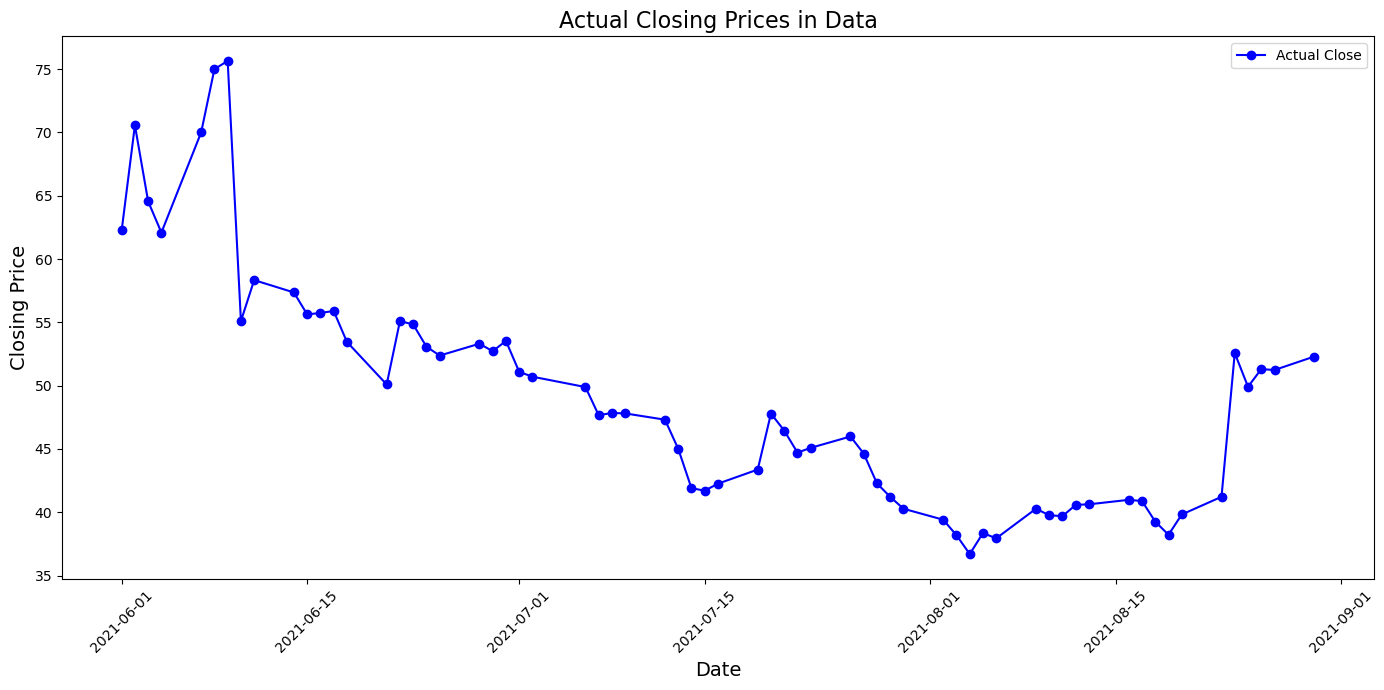

In [3]:
# Ensure the 'Date' column is in datetime format for proper plotting
df = pd.read_csv('stock_data.csv')
df['Date'] = pd.to_datetime(df['Date'])

# Setting the plot size for better readability
plt.figure(figsize=(14, 7))

# Plotting the actual closing prices in the training period
plt.plot(df['Date'], df['Close'], label='Actual Close', color='blue', marker='o')

# Adding title and labels with font size adjustments
plt.title('Actual Closing Prices in Data', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price', fontsize=14)

# Rotating date labels for better visibility
plt.xticks(rotation=45)

# Adding a legend to distinguish the actual values
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

# Data Downloading

This step, I used yfinance to download the stock data

In [2]:
"""
ticker_symbol = 'GME'
start_date = '2021-06-01'
end_date = '2021-08-31'
stock_data = yf.download(ticker_symbol, start=start_date, end=end_date)
stock_data.to_csv('stock_data.csv', index=False)
stock_data.head()
"""

"\nticker_symbol = 'GME'\nstart_date = '2021-06-01'\nend_date = '2021-08-31'\nstock_data = yf.download(ticker_symbol, start=start_date, end=end_date)\nstock_data.to_csv('stock_data.csv', index=False)\nstock_data.head()\n"

This step, I used reddit API to download the reddit posts.

In [ ]:
"""
get_reddit()
"""

# Data Importing

In [ ]:
"""
reddit1 = pd.read_csv('/Users/sundemiao/Library/CloudStorage/OneDrive-Personal/CMU/4th_semester/NLX/Homework/reddit.csv')
reddit2 = pd.read_csv('/Users/sundemiao/Library/CloudStorage/OneDrive-Personal/CMU/4th_semester/NLX/Homework/reddit/reddit_wsb.csv')
reddit3 = pd.read_csv('/Users/sundemiao/Library/CloudStorage/OneDrive-Personal/CMU/4th_semester/NLX/Homework/reddit/dataverse_files/rGME_dataset_features.csv')
"""

In [ ]:
"""
reddit1['date'] = pd.to_datetime(reddit1['date'])
reddit1['date'] = reddit1['date'].apply(days_since_start)
reddit1 = reddit1[['date','title']]
print(reddit1['date'].unique())
print(reddit1.head())
"""

In [ ]:
"""
reddit2['date'] = pd.to_datetime(reddit2['timestamp'])
reddit2['date'] = reddit2['date'].apply(days_since_start)
reddit2 = reddit2[['date','title']]
reddit2 = reddit2[~(reddit2['date'] >= 93)]
reddit2 = reddit2[~(reddit2['date'] < 0)]
print(reddit2['date'].unique())
print(reddit1.head())
"""

In [ ]:
"""
reddit3 = reddit3[['date','title']]
reddit3['date'] = pd.to_datetime(reddit3['date'])
reddit3['date'] = reddit3['date'].apply(days_since_start)
reddit3 = reddit3[~(reddit3['date'] >= 93)]
reddit3 = reddit3[~(reddit3['date'] < 0)]
print(reddit3['date'].unique())
print(reddit3.head())
"""

In [ ]:
"""
reddit = pd.concat([reddit1, reddit2, reddit3])
reddit.to_csv('reddit_concat.csv')
"""

In [131]:
"""
stock_data = pd.read_csv('stock_data.csv')
stock_data = stock_data.reset_index()
stock_data.rename(columns={'Date': 'date'}, inplace=True)
stock_data['date'] = stock_data['date'].apply(days_since_start)
stock_data.head()
date_list = stock_data['date'].tolist()
"""

In [142]:
"""
reddit_data = pd.read_csv('reddit_concat.csv')
reddit_data = reddit_data[reddit_data['date'].isin(date_list)]
reddit_data.to_csv('reddit_concat_cleaned.csv')
"""

In [14]:
"""
reddit_data = pd.read_csv('reddit_concat_cleaned.csv')
nlp_tune = pd.read_csv('all-data.csv', encoding='ISO-8859-1', skiprows=1)
stock_data_label = pd.read_csv('stock_data_label.csv')
"""

# Fine-tuning BERT

For this part, I will used the labeled reddit posts to fine-tune the pre-trained BERT model.

## DataLoader

In [15]:
"""
from transformers import BertModel, BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
nlp_tune = nlp_tune.dropna()
nlp_tune = nlp_tune.drop_duplicates()
nlp_tune.columns = ['labels', 'text']
label_map = {'positive': 2, 'negative': 0, 'neutral': 1}
nlp_tune['labels'] = nlp_tune['labels'].map(label_map)


nlp_train_text, nlp_test_text, nlp_train_label, nlp_test_label = train_test_split(nlp_tune['text'], nlp_tune['labels'], test_size=0.1, random_state=134)


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_and_convert_to_tensor(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=256, return_tensors='pt')

train_dataset = Dataset.from_dict({'text': nlp_train_text.tolist(), 'labels': nlp_train_label.tolist()})
test_dataset = Dataset.from_dict({'text': nlp_test_text.tolist(), 'labels': nlp_test_label.tolist()})


tokenized_train = train_dataset.map(tokenize_and_convert_to_tensor, batched=True)
tokenized_test = test_dataset.map(tokenize_and_convert_to_tensor, batched=True)


train_loader = DataLoader(tokenized_train.remove_columns(["text"]).with_format("torch"), batch_size=80, shuffle=True)
test_loader = DataLoader(tokenized_test.remove_columns(["text"]).with_format("torch"), batch_size=80, shuffle=True)



Map: 100%|██████████| 484/484 [00:00<00:00, 1757.48 examples/s]


## Defining the model

In [16]:
"""
print(BertModel.from_pretrained('bert-base-uncased').config.hidden_size)

768


In [17]:
"""
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        return self.classifier(pooled_output)
 
model = SentimentClassifier(n_classes=3)


## Train Configuration

In [18]:
"""
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('mps')
model = model.to(device)
optimizer = AdamW(model.parameters(), lr=5e-4)
EPOCHS = 10
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
loss_fn = nn.CrossEntropyLoss().to(device)

/jet/home/dsun2/.local/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Train

In [8]:
"""
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    model = model.to(device)
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["labels"].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["labels"].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
    
    return correct_predictions.double() / n_examples, np.mean(losses)

In [51]:
"""
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device, scheduler, len(tokenized_train))
    print(f'Train loss {train_loss} accuracy {train_acc}')
    test_acc, test_loss = eval_model(model, test_loader, loss_fn, device, len(tokenized_test))
    print(f'Test loss {test_loss} accuracy {test_acc}')
    torch.save(model.state_dict(), f'model_{epoch}.pth')
"""

Epoch 1/10
----------
Train loss 0.7066788397052072 accuracy 0.6853468075333027
Test loss 0.6561072298458644 accuracy 0.7107438016528926
Epoch 2/10
----------
Train loss 0.4818464057012038 accuracy 0.8146531924666973
Test loss 0.5098747142723629 accuracy 0.7975206611570248
Epoch 3/10
----------
Train loss 0.4266638146205382 accuracy 0.8592099219108865
Test loss 0.5701614022254944 accuracy 0.768595041322314
Epoch 4/10
----------
Train loss 0.37530426951971924 accuracy 0.8870004593477262
Test loss 0.6859773482595172 accuracy 0.8037190082644629
Epoch 5/10
----------
Train loss 0.3600752277807756 accuracy 0.9030776297657327
Test loss 0.6785308207784381 accuracy 0.7995867768595042
Epoch 6/10
----------
Train loss 0.3024226996031674 accuracy 0.9193844740468535
Test loss 0.6046591188226428 accuracy 0.7851239669421488
Epoch 7/10
----------
Train loss 0.24477534876628357 accuracy 0.9375287092328893
Test loss 0.6365327052772045 accuracy 0.7913223140495868
Epoch 8/10
----------
Train loss 0.19591

# Use the Fine-tuned to Generate Embeddings for Reddit Posts
convert the reddit posts into [1,768] tensor

## Model Definition

In [9]:
"""
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        return self.classifier(pooled_output)
 
model = SentimentClassifier(n_classes=3)

class BertFeatureExtractor(nn.Module):
    def __init__(self):
        super(BertFeatureExtractor, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        return pooled_output

bert_feature_extractor = BertFeatureExtractor()
model.load_state_dict(torch.load('model_9.pth'))
bert_feature_extractor.bert.load_state_dict(model.bert.state_dict())
bert_feature_extractor = bert_feature_extractor.to(device)
bert_feature_extractor.eval()

BertFeatureExtractor(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementw

## Data Wrangling

In [10]:
"""
reddit_data.sort_values('date')
print(len(reddit_data['date'].unique()))
print(np.min(reddit_data.groupby('date').agg('count')['title']))
print(reddit_data.head())

64
242
   Unnamed: 0.1  Unnamed: 0  date  \
0             0           0     0   
1             1           1     2   
2             4           4     7   
3             5           5     8   
4             6           6     8   

                                               title  
0  GameStop Board of Directors Compensation - Jun...  
1                    The "new" market is exhausting.  
2  Crayon-eating retail investors deciding today ...  
3  The Love of Safety? Safe places to put money r...  
4                  🚀 GME Q1 Earnings Megathread 💎🙌 🚀  


In [ ]:
"""
date_list = stock_data_label['date'].tolist()
reddit_data = reddit_data.reset_index(drop=True)
sample_reddit = pd.DataFrame(columns=['date', 'text'])
for date in date_list:  # 从0到93
    daily_posts = reddit_data[reddit_data['date'] == date]

    if len(daily_posts) < 100:
        sampled_posts = daily_posts
    else:
        sampled_posts = daily_posts.sample(n=100)
    concatenated_text = ' '.join(sampled_posts['title'].tolist())
    sample_reddit = sample_reddit.append({'date': date, 'text': concatenated_text}, ignore_index=True)
print(sample_reddit.head())

In [28]:
sample_reddit.head()

,date,text
0,0,Spacetime T-Shirt! Bias confirmed! Wrinkle bra...
1,1,THIS IS AMERICA Kenny these are rookie numbers...
2,2,Browsing WSB and my conclusion Post MOASS: Hap...
3,3,Be prepared for another six months Enjoy your ...
4,6,$300 Apes! We're coming to pick u up 🚀🚀🚀 is it...


## Embedding with Bert

In [29]:
"""
def get_embeddings(sample_reddit, bert_feature_extractor):
    embeddings = []
    
    for text in sample_reddit['text']:
        inputs = tokenizer(text, return_tensors="pt", padding='max_length', truncation=True, max_length=512)
        inputs = inputs.to(device)
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        with torch.no_grad():
            embedding = bert_feature_extractor(input_ids=input_ids, attention_mask=attention_mask)
        
        embeddings.append(embedding)
    
    return embeddings

embeddings = get_embeddings(sample_reddit, bert_feature_extractor)


In [31]:
"""
torch.save(embeddings, 'embedding.pth')

# Use the fine-tuned BERT to Generate Possibility for Post Belonging to Labels
Use the fine-tuned BERT to generate possibility of the post belonging to one of the 3 labels

In [32]:
"""
def get_labels(sample_reddit, model):
    labels = []  # 存储所有文本的embeddings
    
    for text in sample_reddit['text']:
        # 对文本进行编码
        inputs = tokenizer(text, return_tensors="pt", padding='max_length', truncation=True, max_length=512)
        inputs = inputs.to(device)
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        
        
        with torch.no_grad():
            label = model(input_ids=input_ids, attention_mask=attention_mask)
        
        labels.append(label)
    
    return labels

# 获取embeddings
model = model.to(device)
model = model.eval()
labels = get_labels(sample_reddit, model)

In [33]:
"""
numpy_arrays = [t.cpu().numpy() for t in labels]
stacked_array = np.vstack(numpy_arrays)
label_df = pd.DataFrame(stacked_array, columns=['label1', 'label2', 'label3'])
label_df.head()

,label1,label2,label3
0,0.341291,0.403997,0.137966
1,0.342866,0.432725,0.338033
2,0.374280,0.447999,0.391461
3,0.386421,0.454372,0.342673
4,0.324074,0.466839,0.004218


Text(0.5, 1.0, 'Possibility of the Reddit Posts of the Day Belonging to Labels')

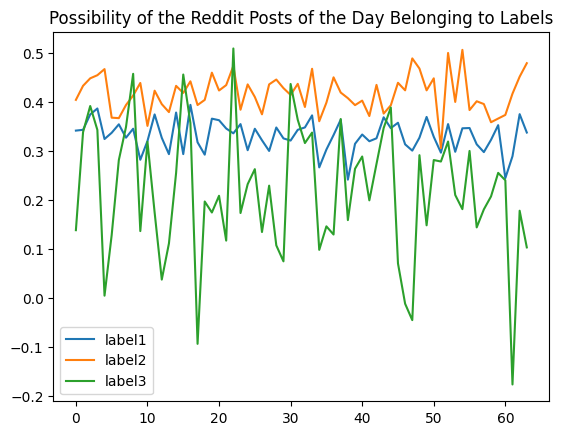

In [37]:
label = pd.read_csv('stock_data_label.csv')
label = label[['label1','label2','label3']]
label.plot()
plt.title('Possibility of the Reddit Posts of the Day Belonging to Labels')

# Failed

## Failed Data Preparation for LSTM in PyTorch

### Data Preparation

In [42]:
"""
stock_data_merged = pd.concat([label_df,stock_data_label],axis=1)
stock_data_merged.head()
stock_data_merged.to_csv('stock_data_label.csv',index=False)
"""

In [57]:
"""
stock_data_merged = pd.read_csv('stock_data_label.csv')
embeddings = torch.load('embedding.pth')
stock_data_merged=stock_data_merged[['Adj Close','date','label1', 'label2', 'label3',  'Open', 'High', 'Low', 'Close', 'Volume']]
stock_data_merged = stock_data_merged.values
stock_data_merged = torch.tensor(stock_data_merged)
embeddings_tensor = torch.stack(embeddings, dim=0)
embeddings_tensor = embeddings_tensor.reshape(64,768)
embeddings_tensor = embeddings_tensor.to(device)
stock_data_merged = stock_data_merged.to(device)
final_merge = torch.cat((stock_data_merged,embeddings_tensor),dim=1)
final_merge.shape
torch.save(final_merge, 'final_merge.pth')
"""

In [4]:
final_merge = torch.load('final_merge.pth')

In [5]:
final_merge.shape

torch.Size([64, 778])

## Data Loader

In [6]:
from torch.utils.data import TensorDataset, DataLoader
targets = final_merge[:, 0]  # First column is the target
features = final_merge[:, 1:]  # The rest are features

# Define the number of timesteps for inputs and the indices for splitting
num_timesteps = 15
train_test_split_idx = final_merge.shape[0] - 20  # Last 10 for testing

def create_sequences(features, targets, num_timesteps):
    X, y = [], []
    for i in range(len(features) - num_timesteps):
        X.append(features[i:i+num_timesteps])
        y.append(targets[i+num_timesteps])
    return torch.stack(X), torch.stack(y)

# Create sequences for the entire dataset
X, y = create_sequences(features, targets, num_timesteps)

# Split into training and testing datasets
X_train, y_train = X[:train_test_split_idx], y[:train_test_split_idx]
X_test, y_test = X[train_test_split_idx:], y[train_test_split_idx:]


mean = X_train.mean(dim=(0, 1))  
std = X_train.std(dim=(0, 1))    


def standardize(data, mean, std):
    return (data - mean) / std


X_train_standardized = standardize(X_train, mean, std)
X_test_standardized = standardize(X_test, mean, std)
X_all_standardized = standardize(X, mean, std) 


train_dataset_standardized = TensorDataset(X_train_standardized, y_train)
test_dataset_standardized = TensorDataset(X_test_standardized, y_test)
all_dataset_standardized = TensorDataset(X_all_standardized, y)


batch_size = 20
train_loader = DataLoader(train_dataset_standardized, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset_standardized, batch_size=batch_size, shuffle=False)
all_loader = DataLoader(all_dataset_standardized, batch_size=59, shuffle=False)


In [7]:
X_train.shape

torch.Size([44, 15, 777])

In [8]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X.shape)
print(y.shape)

torch.Size([44, 15, 777])
torch.Size([44])
torch.Size([5, 15, 777])
torch.Size([5])
torch.Size([49, 15, 777])
torch.Size([49])


## Failed Pytorch MODEL1- Predict Stock Price with Reddit Embedding, Reddit Label and Historical Price

In [34]:
class Everything_model(nn.Module):
    def __init__(self, input_dim_price, input_dim_reddit, hidden_dim, output_dim, num_layers, dropout_rate):
        super(Everything_model, self).__init__()
        
        # LSTM for historical closing prices
        self.lstm_price = nn.LSTM(input_size=input_dim_price,
                                  hidden_size=hidden_dim,
                                  num_layers=num_layers,
                                  batch_first=True,
                                  dropout=dropout_rate)
        
        # LSTM for Reddit features
        self.lstm_reddit = nn.LSTM(input_size=input_dim_reddit,
                                   hidden_size=hidden_dim,
                                   num_layers=num_layers,
                                   batch_first=True,
                                   dropout=dropout_rate)
        
        # A dropout layer for regularization
        self.dropout = nn.Dropout(dropout_rate)
        
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Multiply by 2 for concatenation of two LSTMs' outputs
        self.activation = nn.ReLU()
        self.fc2 = nn.Linear(output_dim, 1)
        
    
    def forward(self, price_data, reddit_data):
        price_output, _ = self.lstm_price(price_data)
        reddit_output, _ = self.lstm_reddit(reddit_data)
        
        price_last_hidden = price_output[:, -1, :]
        reddit_last_hidden = reddit_output[:, -1, :]
        
        combined_features = torch.cat((price_last_hidden, reddit_last_hidden), dim=1)
        
        combined_features = self.dropout(combined_features)
        
        prediction = self.fc(combined_features)
        prediction = self.activation(prediction)
        prediction = self.fc2(prediction)
        
        return prediction


In [39]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('mps')
input_dim_price = 9
input_dim_reddit = 768
hidden_dim = 50
output_dim = 50
num_layers = 2
dropout_rate = 0.2
num_epochs = 50

everything_model = Everything_model(input_dim_price, input_dim_reddit, hidden_dim, output_dim, num_layers, dropout_rate)
everything_model = everything_model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(everything_model.parameters(), lr=0.001)

In [40]:
train_mae_list = []
test_mae_list = []

for epoch in range(num_epochs):
    everything_model.train()
    train_losses = []
    
    for x, y in train_loader:
        optimizer.zero_grad()
        price_data = x[:,:,:9].float()
        reddit_data = x[:,:,9:].float()
        y = y.float()
        predictions = everything_model(price_data, reddit_data)
        loss = criterion(predictions, y)
        loss.backward()
        optimizer.step()
        train_losses.append(torch.abs(predictions - y).mean().item())
    
    train_mae = np.mean(train_losses)
    train_mae_list.append(train_mae)
    
    
    everything_model.eval()
    test_losses = []
    with torch.no_grad():
        for x, y in test_loader:
            price_data = x[:,:,:9].float()
            reddit_data = x[:,:,9:].float()
            y = y.float()
            predictions = final_model(price_data, reddit_data)
            test_losses.append(torch.abs(predictions - y).mean().item())
    
    test_mae = np.mean(test_losses)
    test_mae_list.append(test_mae)
    
    
    print(f'Epoch {epoch+1}, Train MAE: {train_mae}, Test MAE: {test_mae}')
    
    
    torch.save(everything_model.state_dict(), f'lstm_pth/everything_model_{epoch+1}.pth')

Epoch 1, Train MAE: 47.07180881500244, Test MAE: 51.58727264404297
Epoch 2, Train MAE: 46.40310001373291, Test MAE: 51.58667755126953
Epoch 3, Train MAE: 47.157999992370605, Test MAE: 51.58656311035156
Epoch 4, Train MAE: 46.77945613861084, Test MAE: 51.59479522705078
Epoch 5, Train MAE: 46.94879722595215, Test MAE: 51.58565902709961
Epoch 6, Train MAE: 45.83380889892578, Test MAE: 51.59356689453125
Epoch 7, Train MAE: 46.32043743133545, Test MAE: 51.58430862426758
Epoch 8, Train MAE: 43.52558517456055, Test MAE: 51.60004806518555
Epoch 9, Train MAE: 42.300353050231934, Test MAE: 51.58474349975586
Epoch 10, Train MAE: 41.79422092437744, Test MAE: 51.59077453613281
Epoch 11, Train MAE: 39.17222499847412, Test MAE: 51.59632873535156
Epoch 12, Train MAE: 37.32818126678467, Test MAE: 51.59098434448242
Epoch 13, Train MAE: 35.68482303619385, Test MAE: 51.58509063720703
Epoch 14, Train MAE: 32.79679012298584, Test MAE: 51.58908462524414
Epoch 15, Train MAE: 30.28279972076416, Test MAE: 51.59

## Failed Pytorch MODEL2 - Predict Stock Price with Reddit Label, and Historical Price

In [9]:
class Only_History(nn.Module):
    def __init__(self, input_dim_price, hidden_dim, output_dim, num_layers, dropout_rate):
        super(Only_History, self).__init__()
        
        # LSTM for historical closing prices
        self.lstm_price = nn.LSTM(input_size=input_dim_price,
                                  hidden_size=hidden_dim,
                                  num_layers=num_layers,
                                  batch_first=True,
                                  dropout=dropout_rate)
        
        # A dropout layer for regularization
        self.dropout = nn.Dropout(dropout_rate)
        
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)  # Multiply by 2 for concatenation of two LSTMs' outputs
        self.activation = nn.ReLU()
        self.fc2 = nn.Linear(output_dim, 1)
        
    
    def forward(self, price_data):
        # price_data shape: [batch_size, seq_length, input_dim_price]
        # reddit_data shape: [batch_size, seq_length, input_dim_reddit]
        # LSTM outputs for price and reddit
        price_output, _ = self.lstm_price(price_data)
        
        # Use only the last hidden state of sequences
        price_last_hidden = price_output[:, -1, :]
        
        # Concatenate the last hidden states
        combined_features = price_last_hidden
        
        # Apply dropout
        combined_features = self.dropout(combined_features)
        
        # Final prediction
        prediction = self.fc(combined_features)
        prediction = self.activation(prediction)
        prediction = self.fc2(prediction)
        
        return prediction


In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('mps')
input_dim_price = 9
hidden_dim = 50
output_dim = 50
num_layers = 2
dropout_rate = 0.2
num_epochs = 50

history_label = Only_History(input_dim_price, hidden_dim, output_dim, num_layers, dropout_rate)
history_label = history_label.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(history_label.parameters(), lr=0.001)

In [11]:
history_label_train_mae_list = []
history_label_test_mae_list = []

for epoch in range(num_epochs):
    history_label.train()
    train_losses = []
    
    for x, y in train_loader:
        optimizer.zero_grad()
        price_data = x[:,:,:9].float()
        y = y.float()
        predictions = history_label(price_data)
        loss = criterion(predictions, y)
        loss.backward()
        optimizer.step()
        train_losses.append(torch.abs(predictions - y).mean().item())
    
    train_mae = np.mean(train_losses)
    history_label_train_mae_list.append(train_mae)
    
    
    history_label.eval()
    test_losses = []
    with torch.no_grad():
        for x, y in test_loader:
            price_data = x[:,:,:9].float()
            y = y.float()
            predictions = history_label(price_data)
            test_losses.append(torch.abs(predictions - y).mean().item())
    
    test_mae = np.mean(test_losses)
    history_label_test_mae_list.append(test_mae)
    
    
    print(f'Epoch {epoch+1}, Train MAE: {train_mae}, Test MAE: {test_mae}')
    
    
    torch.save(history_label.state_dict(), f'history_label/history_label_epoch_{epoch+1}.pth')
    

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Train MAE: 44.43610127766927, Test MAE: 51.37532043457031
Epoch 2, Train MAE: 45.549329121907554, Test MAE: 51.33176803588867
Epoch 3, Train MAE: 44.08929697672526, Test MAE: 51.28791809082031
Epoch 4, Train MAE: 44.203104654947914, Test MAE: 51.22583770751953
Epoch 5, Train MAE: 44.67429987589518, Test MAE: 51.12563705444336
Epoch 6, Train MAE: 43.667893727620445, Test MAE: 50.93955993652344
Epoch 7, Train MAE: 44.544150034586586, Test MAE: 50.60930252075195
Epoch 8, Train MAE: 43.33633550008138, Test MAE: 50.15086364746094
Epoch 9, Train MAE: 42.69755935668945, Test MAE: 49.62167739868164
Epoch 10, Train MAE: 42.6647580464681, Test MAE: 49.0295295715332
Epoch 11, Train MAE: 41.58847173055013, Test MAE: 48.375946044921875
Epoch 12, Train MAE: 41.125771840413414, Test MAE: 47.66912841796875
Epoch 13, Train MAE: 39.489234924316406, Test MAE: 46.88190460205078
Epoch 14, Train MAE: 39.019447326660156, Test MAE: 46.036781311035156
Epoch 15, Train MAE: 39.29254277547201, Test MAE: 

In [12]:
best_history_label = Only_History(input_dim_price, hidden_dim, output_dim, num_layers, dropout_rate)
best_history_label = best_history_label.to(device)
state_dict = torch.load('history_label/history_label_epoch_50.pth', map_location=device)
best_history_label.load_state_dict(state_dict)
best_history_label.eval()
with torch.no_grad():
        for x, y in all_loader:
            price_data = x[:,:,:9].float()
            y = y.float()
            predictions = history_label(price_data)
            best_history_label_loss = torch.abs(predictions - y).mean().item()
print(predictions)

tensor([[44.1537],
        [44.1531],
        [44.1534],
        [44.1541],
        [44.1536],
        [44.1540],
        [44.1540],
        [44.1543],
        [44.1537],
        [44.1541],
        [44.1543],
        [44.1542],
        [44.1544],
        [44.1544],
        [44.1546],
        [44.1547],
        [44.1540],
        [44.1542],
        [44.1541],
        [44.1543],
        [44.1544],
        [44.1545],
        [44.1547],
        [44.1541],
        [44.1544],
        [44.1543],
        [44.1542],
        [44.1543],
        [44.1544],
        [44.1539],
        [44.1535],
        [44.1545],
        [44.1548],
        [44.1549],
        [44.1544],
        [44.1544],
        [44.1543],
        [44.1537],
        [44.1542],
        [44.1542],
        [44.1544],
        [44.1539],
        [44.1543],
        [44.1543],
        [44.1540],
        [44.1534],
        [44.1533],
        [44.1544],
        [44.1541]], device='cuda:0')


In [13]:
predictions = np.array(predictions.cpu())
predictions = pd.DataFrame( predictions)
predictions.to_csv('prediction_result/label_his_prediction.csv',index=False)

# Keras MODEL3 - Predict Stock Price with Historical Price

In [ ]:
!pip install matplotlib

In [2]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

2024-02-12 19:01:24.642748: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-12 19:01:26.037726: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
df = pd.read_csv('stock_data.csv')
df['Date'] = pd.to_datetime(df['Date']) # This line converts the 'Date' column of the DataFrame df to datetime objects.
df.sort_values('Date', inplace=True)
#  The .values attribute returns the data as a NumPy array. The .reshape(-1, 1) function changes
#  the shape of this array to ensure it has two dimensions, with one column and as many rows as necessary.
close_prices = df['Close'].values.reshape(-1, 1)
# Scale the data -> you can use any appropriate scaling methodology
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close_prices = scaler.fit_transform(close_prices)

In [4]:
SEQUENCE_LENGTH = 15  # You can adjust this value -> parameter tuning
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:(i + sequence_length)]
        y = data[i + sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)
X, y = create_sequences(scaled_close_prices, SEQUENCE_LENGTH)
print(X.shape,y.shape)
TRAIN_END_DATE = '2021-07-31'
train_indices = df[df['Date'] <= TRAIN_END_DATE].index
X_train, y_train = X[:train_indices[-1]-SEQUENCE_LENGTH], y[:train_indices[-1]-SEQUENCE_LENGTH]

(49, 15, 1) (49, 1)


In [6]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50, return_sequences=False),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32)

2024-02-12 15:19:41.468988: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31127 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3a:00.0, compute capability: 7.0


Epoch 1/20


2024-02-12 15:19:44.395407: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8905
2024-02-12 15:19:44.671453: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1512599c5b20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-12 15:19:44.671477: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2024-02-12 15:19:44.746812: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-12 15:19:45.334423: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 [==============================] - 4s 4s/step - loss: 0.0923
Epoch 2/20
1/1 [==============================] - 0s 10ms/step - loss: 0.0674
Epoch 3/20
1/1 [==============================] - 0s 9ms/step - loss: 0.0468
Epoch 4/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0302
Epoch 5/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0174
Epoch 6/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0086
Epoch 7/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0044
Epoch 8/20
1/1 [==============================] - 0s 9ms/step - loss: 0.0048
Epoch 9/20
1/1 [==============================] - 0s 9ms/step - loss: 0.0088
Epoch 10/20
1/1 [==============================] - 0s 9ms/step - loss: 0.0128
Epoch 11/20
1/1 [==============================] - 0s 9ms/step - loss: 0.0139
Epoch 12/20
1/1 [==============================] - 0s 9ms/step - loss: 0.0124
Epoch 13/20
1/1 [==============================] - 0s 9ms/step - loss: 0.0096
Epoch 

In [12]:
business_days = pd.date_range(start=pd.to_datetime(TRAIN_END_DATE) + timedelta(days=1),periods=20, freq='B')
last_sequence = X_train[-1].reshape((1, SEQUENCE_LENGTH, 1))
# Create a list to hold predictions
predictions = []

# Predict future prices
for i in range(len(business_days)):
    # Get the prediction (scaled value)
    current_prediction = model.predict(last_sequence)[0]

    # Append the prediction
    predictions.append(current_prediction)

    # Update the sequence
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = current_prediction

# Inverse transform the predictions to get actual values
predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Create a DataFrame with the predicted stock prices and dates
predictions_df = pd.DataFrame({
    'Date': business_days,
    'Predicted_Close': predicted_prices.flatten()
})

# Show the prediction results
print(predictions_df)

1/1 [==============================] - 0s 19ms/step
         Date  Predicted_Close
0  2021-08-02        43.073399
1  2021-08-03        42.984089
2  2021-08-04        42.883163
3  2021-08-05        42.780910
4  2021-08-06        42.700634
5  2021-08-09        42.650166
6  2021-08-10        42.594475
7  2021-08-11        42.528484
8  2021-08-12        42.449692
9  2021-08-13        42.324589
10 2021-08-16        42.226974
11 2021-08-17        42.156948
12 2021-08-18        42.086460
13 2021-08-19        42.010422
14 2021-08-20        41.955570
15 2021-08-23        41.929874
16 2021-08-24        41.893574
17 2021-08-25        41.859135
18 2021-08-26        41.826931
19 2021-08-27        41.797077


In [13]:
# Continue from the previous predictions_df creation code

# Ensure the 'Date' columns in both DataFrames are in the same format
df['Date'] = pd.to_datetime(df['Date'])
predictions_df['Date'] = pd.to_datetime(predictions_df['Date'])

# Merge the predictions with the actual closing prices from 'df'
predictions_with_actuals_df = predictions_df.merge(df[['Date', 'Close']], on='Date', how='left')

# Rename columns for clarity
predictions_with_actuals_df.rename(columns={'Close': 'Actual_Close'}, inplace=True)

# Show the DataFrame with predictions and actual closing prices
print(predictions_with_actuals_df)

         Date  Predicted_Close  Actual_Close
0  2021-08-02        43.073399     39.412498
1  2021-08-03        42.984089     38.187500
2  2021-08-04        42.883163     36.700001
3  2021-08-05        42.780910     38.360001
4  2021-08-06        42.700634     37.942501
5  2021-08-09        42.650166     40.282501
6  2021-08-10        42.594475     39.762501
7  2021-08-11        42.528484     39.695000
8  2021-08-12        42.449692     40.587502
9  2021-08-13        42.324589     40.630001
10 2021-08-16        42.226974     40.982498
11 2021-08-17        42.156948     40.887501
12 2021-08-18        42.086460     39.262501
13 2021-08-19        42.010422     38.224998
14 2021-08-20        41.955570     39.825001
15 2021-08-23        41.929874     41.222500
16 2021-08-24        41.893574     52.572498
17 2021-08-25        41.859135     49.912498
18 2021-08-26        41.826931     51.305000
19 2021-08-27        41.797077     51.237499


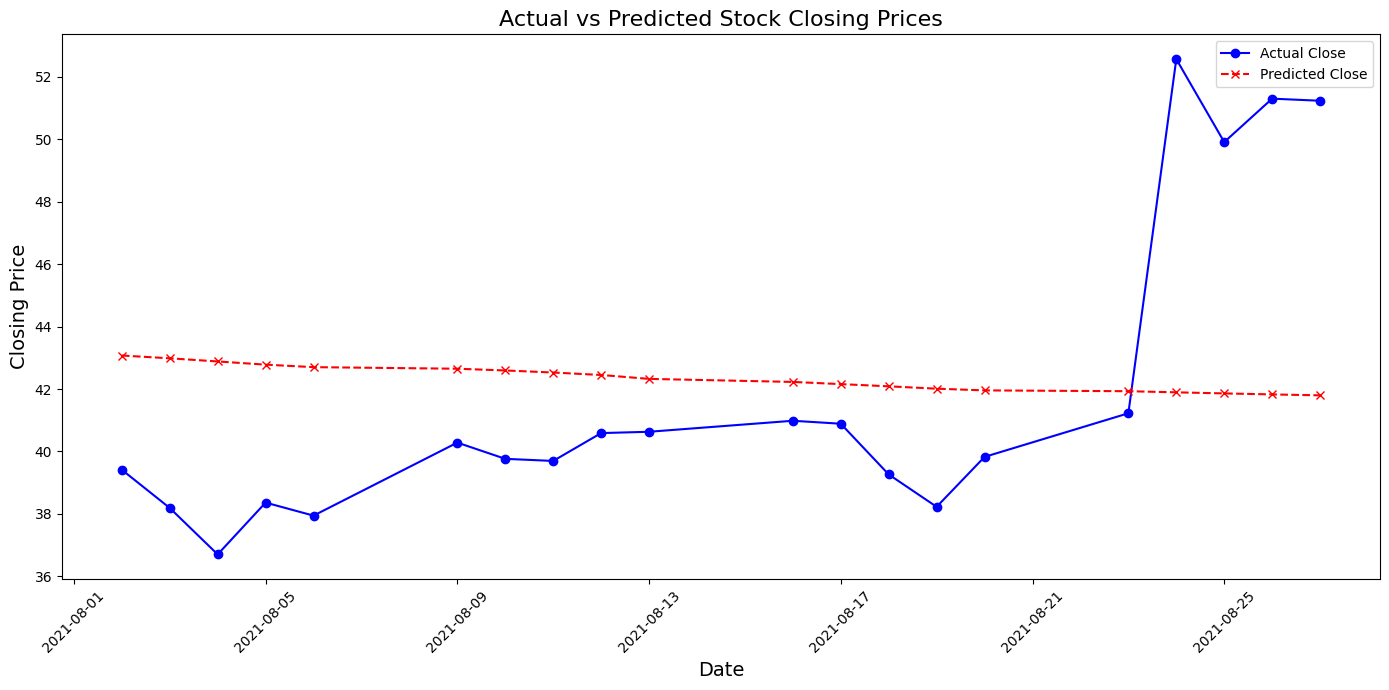

In [16]:
import matplotlib.pyplot as plt

# Ensure the 'Date' column is in datetime format for proper plotting
predictions_with_actuals_df['Date'] = pd.to_datetime(predictions_with_actuals_df['Date'])

# Setting the plot size for better readability
plt.figure(figsize=(14, 7))

# Plotting the actual closing prices
plt.plot(predictions_with_actuals_df['Date'], predictions_with_actuals_df['Actual_Close'], label='Actual Close', color='blue', marker='o')

# Plotting the predicted closing prices
plt.plot(predictions_with_actuals_df['Date'], predictions_with_actuals_df['Predicted_Close'], label='Predicted Close', color='red', linestyle='--', marker='x')

# Adding title and labels with font size adjustments
plt.title('Actual vs Predicted Stock Closing Prices', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price', fontsize=14)

# Rotating date labels for better visibility
plt.xticks(rotation=45)

# Adding a legend to distinguish between actual and predicted values
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

# Keras MODEL4 - to Predict Stock Price with Historical Price and Label

In [10]:
df_all = pd.read_csv('stock_data_label.csv')
df_all.head()
df_all.drop(['Open','High','Low','Adj Close','Volume'],axis=1,inplace=True)
df_all.head()

,label1,label2,label3,date,Close
0,0.341291,0.403997,0.137966,0,62.255001
1,0.342866,0.432725,0.338033,1,70.559998
2,0.374280,0.447999,0.391461,2,64.544998
3,0.386421,0.454372,0.342673,3,62.090000
4,0.324074,0.466839,0.004218,6,70.002502


In [11]:
all = df_all.values
# Scale the data -> you can use any appropriate scaling methodology
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_all = scaler.fit_transform(all)
print(scaled_all[:5,:])
print(scaled_all.shape)

[[0.65595484 0.49075325 0.45923089 0.         0.65626608]
 [0.66627128 0.63401256 0.75085804 0.01111111 0.86954283]
 [0.87205192 0.71017746 0.82873689 0.02222222 0.71507443]
 [0.95158082 0.74195792 0.75762152 0.03333333 0.65202877]
 [0.54317623 0.80412983 0.26427405 0.06666667 0.85522606]]
(64, 5)


In [12]:
SEQUENCE_LENGTH = 15  # You can adjust this value -> parameter tuning
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:(i + sequence_length)]
        y = data[i + sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)
X, y = create_sequences(scaled_all, SEQUENCE_LENGTH)
y = y[:,-1]
y = y.reshape((49,1))
X = np.delete(X,3,axis=2)
print(X.shape,y.shape)
train_indices = df_all[df_all['date'] <= 44].index
X_train, y_train = X[:train_indices[-1]-SEQUENCE_LENGTH], y[:train_indices[-1]-SEQUENCE_LENGTH]


(49, 15, 4) (49, 1)


In [13]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 4)),
    LSTM(50, return_sequences=False),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32)

2024-02-12 19:34:07.593674: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31127 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:16:00.0, compute capability: 7.0


Epoch 1/20


2024-02-12 19:34:11.104598: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8905
2024-02-12 19:34:11.753006: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x14becd678530 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-12 19:34:11.753031: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2024-02-12 19:34:11.910972: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-12 19:34:13.232030: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 [==============================] - 5s 5s/step - loss: 0.0977
Epoch 2/20
1/1 [==============================] - 0s 11ms/step - loss: 0.0423
Epoch 3/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0137
Epoch 4/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0097
Epoch 5/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0076
Epoch 6/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0079
Epoch 7/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0045
Epoch 8/20
1/1 [==============================] - 0s 9ms/step - loss: 0.0049
Epoch 9/20
1/1 [==============================] - 0s 9ms/step - loss: 0.0042
Epoch 10/20
1/1 [==============================] - 0s 9ms/step - loss: 0.0038
Epoch 11/20
1/1 [==============================] - 0s 9ms/step - loss: 0.0037
Epoch 12/20
1/1 [==============================] - 0s 9ms/step - loss: 0.0038
Epoch 13/20
1/1 [==============================] - 0s 9ms/step - loss: 0.0034
Epoch 

In [14]:
last_sequence = X_train[-1].reshape((1, SEQUENCE_LENGTH, 4))
# Create a list to hold predictions
predictions = []

# Predict future prices
for i in range(20):
    # Get the prediction (scaled value)
    current_prediction = model.predict(last_sequence)[0]

    # Append the prediction
    predictions.append(current_prediction)

    # Update the sequence
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = current_prediction



1/1 [==============================] - 0s 17ms/step


In [25]:
# Inverse transform the predictions to get actual values
business_days = pd.date_range(start=pd.to_datetime(TRAIN_END_DATE) + timedelta(days=1),periods=20, freq='B')
predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 5))
predicted_prices = pd.DataFrame(predicted_prices)
predicted_prices.to_csv('jiaprediction2.csv',index=False)
predicted_prices = pd.read_csv('jiaprediction2.csv').values[-20:]
# Create a DataFrame with the predicted stock prices and dates
predictions_df = pd.DataFrame({
    'Date': business_days,
    'Predicted_Close': predicted_prices.flatten()
})


In [26]:
# Continue from the previous predictions_df creation code
df = pd.read_csv('stock_data.csv')
# Ensure the 'Date' columns in both DataFrames are in the same format
df['Date'] = pd.to_datetime(df['Date'])
predictions_df['Date'] = pd.to_datetime(predictions_df['Date'])

# Merge the predictions with the actual closing prices from 'df'
predictions_with_actuals_df = predictions_df.merge(df[['Date', 'Close']], on='Date', how='left')

# Rename columns for clarity
predictions_with_actuals_df.rename(columns={'Close': 'Actual_Close'}, inplace=True)

# Show the DataFrame with predictions and actual closing prices
print(predictions_with_actuals_df)

         Date  Predicted_Close  Actual_Close
0  2021-08-02        46.070313     39.412498
1  2021-08-03        45.279043     38.187500
2  2021-08-04        44.706098     36.700001
3  2021-08-05        43.511164     38.360001
4  2021-08-06        44.183421     37.942501
5  2021-08-09        46.182866     40.282501
6  2021-08-10        44.322093     39.762501
7  2021-08-11        46.254183     39.695000
8  2021-08-12        45.120382     40.587502
9  2021-08-13        46.391292     40.630001
10 2021-08-16        44.465935     40.982498
11 2021-08-17        44.266804     40.887501
12 2021-08-18        44.300828     39.262501
13 2021-08-19        44.111175     38.224998
14 2021-08-20        46.611525     39.825001
15 2021-08-23        50.954799     41.222500
16 2021-08-24        47.695988     52.572498
17 2021-08-25        48.068294     49.912498
18 2021-08-26        48.948983     51.305000
19 2021-08-27        50.496709     51.237499


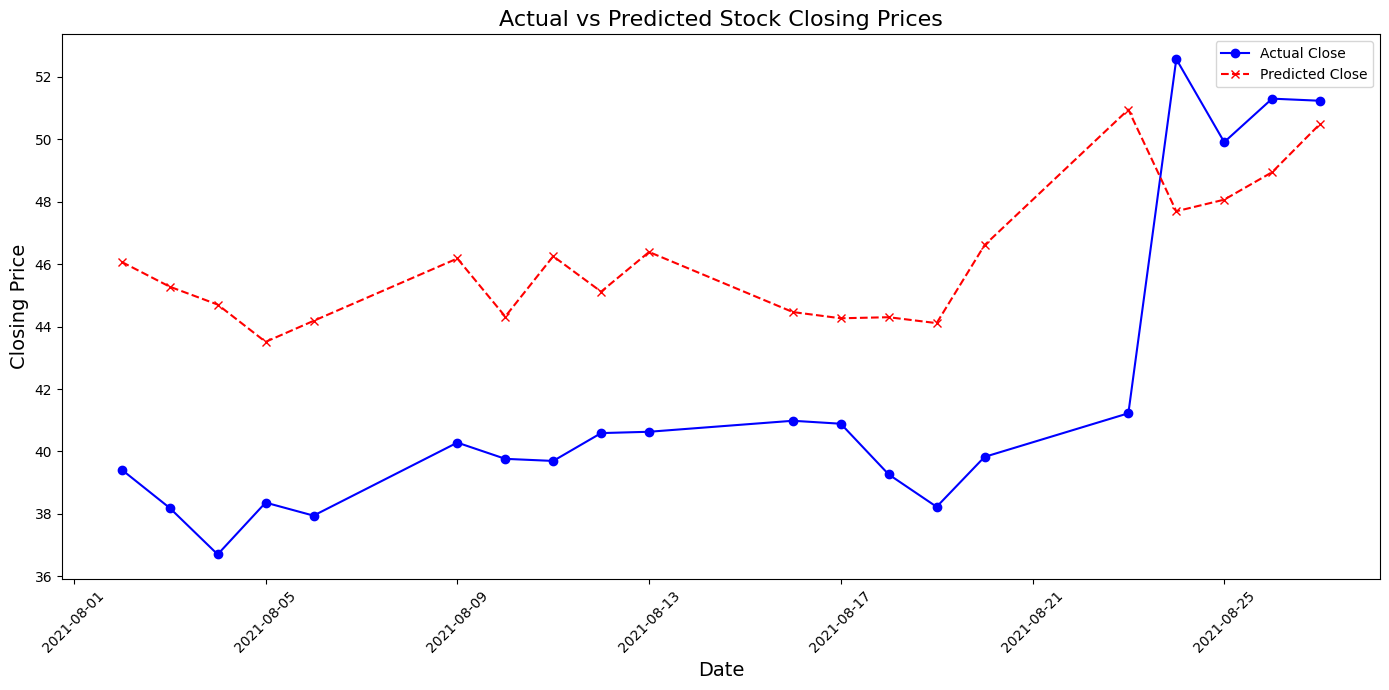

In [40]:
import matplotlib.pyplot as plt

# Ensure the 'Date' column is in datetime format for proper plotting
predictions_with_actuals_df['Date'] = pd.to_datetime(predictions_with_actuals_df['Date'])

# Setting the plot size for better readability
plt.figure(figsize=(14, 7))

# Plotting the actual closing prices
plt.plot(predictions_with_actuals_df['Date'], predictions_with_actuals_df['Actual_Close'], label='Actual Close', color='blue', marker='o')


# Plotting the predicted closing prices
plt.plot(predictions_with_actuals_df['Date'], predictions_with_actuals_df['Predicted_Close'], label='Predicted Close', color='red', linestyle='--', marker='x')

# Adding title and labels with font size adjustments
plt.title('Actual vs Predicted Stock Closing Prices', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price', fontsize=14)

# Rotating date labels for better visibility
plt.xticks(rotation=45)

# Adding a legend to distinguish between actual and predicted values
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Possibility of the Reddit Posts of the Day Belonging to Labels in the August')

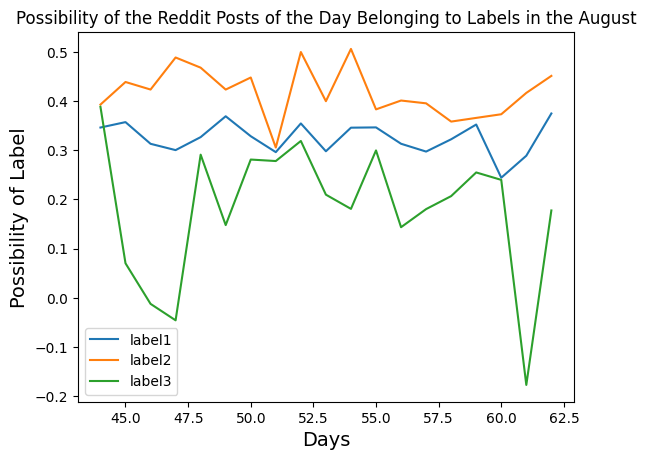

In [51]:
label = pd.read_csv('stock_data_label.csv')
label = label[['label1','label2','label3']]
label = label[-20:-1]
label.plot()
plt.xlabel('Days', fontsize=14)
plt.ylabel('Possibility of Label', fontsize=14)
plt.title('Possibility of the Reddit Posts of the Day Belonging to Labels in the August')

# Discussion
## Part 4: Conclusion and Future Directions (20%)
## Summarize:

This notebook integrated API-Scraping, time-series forecasting and sentiment analysis models to predict GameStop's stock prices. The time-series model utilized LSTM networks to capture the sequential dependencies in stock price data, while the sentiment analysis model (fine-tuned BERT) extracted public sentiment related to GameStop from social media platforms like Reddit. By fusing predictions from both models, an attempt was made to achieve more accurate stock price forecasts.

## Model Accuracy:
For the final model, an MSE of 0.0033 was achieved.
Although the model successfully predicted stock price trends during certain periods, overall accuracy leaves room for improvement. Predictions were particularly unstable during times of significant sentiment shifts on social media.

## Sensitivity to Social Media Events: 
The model demonstrates potential in reflecting the impact of social media sentiment on stock prices, showcasing the value of incorporating social media data into stock price prediction models.


## Discuss:
The GameStop short squeeze challenged traditional forecasting models, highlighting the influence of social media in modern financial markets and the limitations of traditional models in addressing non-classical financial indicators. Integrating social media sentiment data into prediction models enhances the ability to perceive market sentiment shifts, improving prediction accuracy and timeliness.

However, mining social media raises ethical concerns, including privacy protection, data consent, and the risk of market manipulation. Ethical principles must be carefully considered when utilizing social media data.

## Propose:
Improving Model Adaptability: Future research could explore more advanced machine learning and deep learning techniques, such as Transformer models, to better handle the complexity of time-series and social media text data.

Data Quality and Ethics: Efforts should focus on improving data cleaning and preprocessing methods to reduce noise and bias while ensuring data collection and use adhere to ethical standards.

Multisource Data Fusion: Investigating the integration of additional data sources, like news reports and financial blogs, could provide a more comprehensive view of the market.

Model Explainability: Enhancing model explainability will help analysts understand the drivers behind predictions, especially when social media data significantly impacts forecasts.